In [ ]:
pip install transformers

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount("/content/drive")

dir = "./drive/My Drive/ML/Final/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
from transformers import BertTokenizer

labels = {'國立臺灣大學': 0, '國立清華大學': 1, '國立交通大學': 2, '國立成功大學': 3, '國立政治大學': 4,
          '國立中央大學': 5, '國立中山大學': 6, '國立中興大學': 7, '國立中正大學': 8, 
          '輔仁大學': 9, '逢甲大學': 10, '東海大學': 11, '義守大學': 12, '中原大學': 13, '其他': 14}
# school_maps = [{'國立臺灣大學': 0, '國立清華大學': 1, '國立交通大學': 2, '國立成功大學': 3, '國立政治大學': 4},
#                {'國立中央大學': 0, '國立中山大學': 1, '國立中興大學': 2, '國立中正大學': 3}]
# labels = {'頂大': 0, '中字輩': 1, '其他': 2}
NUM_LABELS = len(labels)
TITLE_MAX_LEN = 20
MAX_LEN = 50

PRETRAINED_MODEL_NAME = "bert-base-chinese" # pre-trained chinese bert model
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME) # get tokenizer

In [ ]:
"""
實作一個可以用來讀取訓練 / 測試集的 Dataset。
此 Dataset 每次將 csv 裡的一筆成對句子轉換成 BERT 相容的格式，並回傳 3 個 tensors：
- tokens_tensor：兩個句子合併後的索引序列，包含 [CLS] 與 [SEP]
- segments_tensor：可以用來識別兩個句子界限的 binary tensor
- label_tensor：將分類標籤轉換成類別索引的 tensor, 如果是測試集則回傳 None
"""
import pandas as pd
from torch.utils.data import Dataset

class DcardDataset(Dataset):
    # 讀取 csv 檔並初始化參數
    def __init__(self, filepath, tokenizer):
        df = pd.read_csv(filepath).fillna("")
        # 將非指定的學校 label 為 '其他'
        for i in range(len(df.index)):
          # if df.loc[i, 'school'] in school_maps[0]:
          #   df.loc[i, 'school'] = '頂大'
          # elif df.loc[i, 'school'] in school_maps[1]:
          #   df.loc[i, 'school'] = '中字輩'
          # else:
          #   df.loc[i, 'school'] = '其他'
          if df.loc[i, 'school'] not in labels:
            df.loc[i, 'school'] = '其他'
        self.df = df
        self.len = len(self.df)
        self.label_map = labels
        self.tokenizer = tokenizer
    
    # 定義回傳一筆訓練 / 測試數據的函式
    def __getitem__(self, idx):
        title = self.df.loc[idx, 'title'][:TITLE_MAX_LEN]
        content = self.df.loc[idx, 'content'][:MAX_LEN]
        label = self.df.loc[idx, 'school']
        # 將 label 文字也轉換成索引方便轉換成 tensor
        label_id = self.label_map[label]
        label_tensor = torch.tensor(label_id)
            
        # BERT 輸入層的第一個 token 必是 [CLS]
        word_pieces = ["[CLS]"]

        # 建立標題的 BERT tokens 並加入分隔符號 [SEP]
        tokens_title = self.tokenizer.tokenize(title)
        word_pieces += tokens_title + ["[SEP]"]
        len_title = len(word_pieces)

        # 建立內文的 BERT tokens 並加入分隔符號 [SEP]
        tokens_content = self.tokenizer.tokenize(content)
        word_pieces += tokens_content + ["[SEP]"]
        len_content = len(word_pieces) - len_title
        
        # 將整個 token 序列轉換成索引序列
        ids = self.tokenizer.convert_tokens_to_ids(word_pieces)
        tokens_tensor = torch.tensor(ids)
        
        # 將標題包含 [SEP] 的 token 位置設為 0，其他為 1 表示內文
        segments_tensor = torch.tensor([0] * len_title + [1] * len_content, dtype=torch.long)
        
        return (tokens_tensor, segments_tensor, label_tensor)
    
    def __len__(self):
        return self.len
    
    
# 初始化一個專門讀取訓練樣本的 Dataset，使用中文 BERT 斷詞
trainset = DcardDataset(dir + "train-100.csv", tokenizer=tokenizer)

In [ ]:
trainset.df.head()

,title,content,excerpt,anonymousSchool,anonymousDepartment,createdAt,commentCount,likeCount,tags,topics,withNickname,forumAlias,school,department,gender,reactions,popular,keyword_word_1,keyword_tf*idf_1,keyword_tf*idf*pf_1,keyword_tf_1,keyword_idf_1,keyword_pf_1,keyword_biword_1,keyword_word_2,keyword_tf*idf_2,keyword_tf*idf*pf_2,keyword_tf_2,keyword_idf_2,keyword_pf_2,keyword_biword_2,keyword_word_3,keyword_tf*idf_3,keyword_tf*idf*pf_3,keyword_tf_3,keyword_idf_3,keyword_pf_3,keyword_biword_3,pf_keyword_word_1,pf_keyword_tf*idf_1,pf_keyword_tf*idf*pf_1,pf_keyword_tf_1,pf_keyword_idf_1,pf_keyword_pf_1,pf_keyword_biword_1,pf_keyword_word_2,pf_keyword_tf*idf_2,pf_keyword_tf*idf*pf_2,pf_keyword_tf_2,pf_keyword_idf_2,pf_keyword_pf_2,pf_keyword_biword_2,pf_keyword_word_3,pf_keyword_tf*idf_3,pf_keyword_tf*idf*pf_3,pf_keyword_tf_3,pf_keyword_idf_3,pf_keyword_pf_3,pf_keyword_biword_3,break_words,comments
0,水源B棟鬼叫,到底是誰在唱歌\n唱到用叫的還這麼難聽= =\n這個音量整棟都聽得到吧....,到底是誰在唱歌，唱到用叫的還這麼難聽= =，這個音量整棟都聽得到吧....,False,True,2021-01-09T09:37:31.225Z,1,3,['HIDE_THUMBNAIL'],[],False,ntu,國立臺灣大學,,M,[{'id': '286f599c-f86a-4932-82f0-f5a06f1eca03'...,True,唱到,0.349982,0.349982,0.04,8.74956,1,[],音量,0.335949,0.335949,0.04,8.39872,1,"['音量整', '音量整棟']",棟,0.301816,0.301816,0.04,7.5454,1,"['整棟', '音量整棟']",唱到,0.349982,0.349982,0.04,8.74956,1,[],音量,0.335949,0.335949,0.04,8.39872,1,"['音量整', '音量整棟']",棟,0.301816,0.301816,0.04,7.5454,1,"['整棟', '音量整棟']","[['到底', '是', '誰', '在', '唱歌'], ['唱到', '用', '叫',...",[]
1,雙轉輔成績門檻調查,剛剛看到某些轉系名額增加的消息，想到一直以來各系的成績門檻都不公開，想知道只能靠問成功的學長...,剛剛看到某些轉系名額增加的消息，想到一直以來各系的成績門檻都不公開，想知道只能靠問成功的學長...,False,True,2021-01-09T07:29:55.032Z,4,14,[],"['台大', '調查', '雙主修', '轉系']",False,ntu,國立臺灣大學,,F,[{'id': '286f599c-f86a-4932-82f0-f5a06f1eca03'...,True,填,0.150699,0.150699,0.0214286,7.03264,1,['填一下'],雙,0.13116,0.13116,0.0214286,6.12079,1,"['雙輔轉', '想雙', '想雙輔轉']",成功,0.120113,0.120113,0.0214286,5.60529,1,['問成功'],填,0.150699,0.150699,0.0214286,7.03264,1,['填一下'],雙,0.13116,0.13116,0.0214286,6.12079,1,"['雙輔轉', '想雙', '想雙輔轉']",成功,0.120113,0.120113,0.0214286,5.60529,1,['問成功'],"[['剛剛', '看到', '某些', '轉系', '名額', '增加', '的', '消息...",[]
2,邵雨薇也太可愛了吧,邵雨薇也太可愛了吧\n邵雨薇也太可愛了吧,邵雨薇也太可愛了吧，邵雨薇也太可愛了吧,False,True,2021-01-09T07:28:00.729Z,0,1,[],"['邵雨薇', '廢文', '嘻嘻']",False,ntu,國立臺灣大學,,M,[{'id': '286f599c-f86a-4932-82f0-f5a06f1eca03'...,True,邵雨薇,1.90558,1.90558,0.166667,11.4335,1,[],可愛,0.833384,0.833384,0.166667,5.0003,1,[],,,,,,,,邵雨薇,1.90558,1.90558,0.166667,11.4335,1,[],可愛,0.833384,0.833384,0.166667,5.0003,1,[],,,,,,,,"[['邵雨薇', '也', '太', '可愛', '了', '吧'], ['邵雨薇', '也...",[]
3,海科概,有人可以分享一下上課錄音\n或是筆記嗎 感謝\n投影片有夠難下手,有人可以分享一下上課錄音，或是筆記嗎 感謝，投影片有夠難下手,False,True,2021-01-09T07:20:24.189Z,3,0,[],[],False,ntu,國立臺灣大學,,M,[],True,投影片,0.675536,0.675536,0.0625,10.8086,1,"['投影片有夠', '投影片有夠難']",錄音,0.492769,0.492769,0.0625,7.8843,1,"['上課錄音', '一下上課錄音']",筆記,0.443491,0.443491,0.0625,7.09586,1,[],投影片,0.675536,0.675536,0.0625,10.8086,1,"['投影片有夠', '投影片有夠難']",錄音,0.492769,0.492769,0.0625,7.8843,1,"['上課錄音', '一下上課錄音']",筆記,0.443491,0.443491,0.0625,7.09586,1,[],"[['有', '人', '可以', '分享', '一下', '上課', '錄音'], ['或...",[]
4,【心理諮商研究問卷】,大家好，我們是一群對心理諮商有興趣的同學，目前正在針對心理諮商做研究，希望大家能幫我們填答這...,大家好，我們是一群對心理諮商有興趣的同學，目前正在針對心理諮商做研究，希望大家能幫我們填答這...,False,True,2021-01-09T06:51:20.863Z,0,3,[],['問卷'],False,ntu,國立臺灣大學,,F,[{'id': '286f599c-f86a-4932-82f0-f5a06f1eca03'...,True,諮商,0.393423,0.393423,0.0446429,8.81267,1,['心理諮商'],心理,0.276637,0.276637,0.0446429,6.19666,1,['心理諮商'],問卷,0.225843,0.225843,0.0267857,8.43148,1,[],諮商,0.393423,0.393423,0.0446429,8.81267,1,['心理諮商'],心理,0.276637,0.276637,0.0446429,6.19666,1,['心理諮商'],問卷,0.225843,0.225843,0.0267857,8.43148,1,[],"[['大家', '好', '，', '我們', '是', '一', '群', '對', '心...",[]


In [ ]:
# 選擇一個樣本
sample_idx = 0

# 將原始文本拿出做比較
title = trainset.df.loc[sample_idx, 'title']
content = trainset.df.loc[sample_idx, 'content']
label = trainset.df.loc[sample_idx, 'school']

# 利用剛剛建立的 Dataset 取出轉換後的 id tensors
tokens_tensor, segments_tensor, label_tensor = trainset[sample_idx]

# 將 tokens_tensor 還原成文本
tokens = tokenizer.convert_ids_to_tokens(tokens_tensor.tolist())
combined_text = "".join(tokens)

print(f"""[原始文本]
標題 ：{title}
內文 ：{content}
分類 ：{label}

--------------------

[Dataset 回傳的 tensors]
tokens_tensor  ：{tokens_tensor}

segments_tensor：{segments_tensor}

label_tensor   ：{label_tensor}

--------------------

[還原 tokens_tensors]
{combined_text}
""")

[原始文本]
標題 ：水源B棟鬼叫
內文 ：到底是誰在唱歌
唱到用叫的還這麼難聽= =
這個音量整棟都聽得到吧....
分類 ：國立臺灣大學

--------------------

[Dataset 回傳的 tensors]
tokens_tensor  ：tensor([ 101, 3717, 3975,  100, 3477, 7787, 1373,  102, 1168, 2419, 3221, 6306,
        1762, 1548, 3625, 1548, 1168, 4500, 1373, 4638, 6917, 6857, 7938, 7432,
        5481,  134,  134, 6857,  943, 7509, 7030, 3146, 3477, 6963, 5481, 2533,
        1168, 1416,  119,  119,  119,  119,  102])

segments_tensor：tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

label_tensor   ：0

--------------------

[還原 tokens_tensors]
[CLS]水源[UNK]棟鬼叫[SEP]到底是誰在唱歌唱到用叫的還這麼難聽==這個音量整棟都聽得到吧....[SEP]



In [ ]:
"""
實作可以一次回傳一個 mini-batch 的 DataLoader
這個 DataLoader 吃我們上面定義的 `DcardDataset`，
回傳訓練 BERT 時會需要的 4 個 tensors：
- tokens_tensors  : (batch_size, max_seq_len_in_batch)
- segments_tensors: (batch_size, max_seq_len_in_batch)
- masks_tensors   : (batch_size, max_seq_len_in_batch)
- label_ids       : (batch_size)
"""

from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

# 這個函式的輸入 'samples' 是一個 list，裡頭的每個 element 都是
# 剛剛定義的 'DcardDataset' 回傳的一個樣本，每個樣本都包含 3 tensors：
# - tokens_tensor
# - segments_tensor
# - label_tensor
# 它會對前兩個 tensors 作 zero padding，並產生前面說明過的 masks_tensors
def create_mini_batch(samples):
    tokens_tensors = [s[0] for s in samples]
    segments_tensors = [s[1] for s in samples]
    
    # 測試集有 labels
    if samples[0][2] is not None:
        label_ids = torch.stack([s[2] for s in samples])
    else:
        label_ids = None
    
    # zero pad 到同一序列長度
    tokens_tensors = pad_sequence(tokens_tensors, batch_first=True)
    segments_tensors = pad_sequence(segments_tensors, batch_first=True)
    
    # attention masks，將 tokens_tensors 裡頭不為 zero padding 的位置設為 1 讓 BERT 只關注這些位置的 tokens
    masks_tensors = torch.zeros(tokens_tensors.shape, 
                                dtype=torch.long)
    masks_tensors = masks_tensors.masked_fill(
        tokens_tensors != 0, 1)
    
    return tokens_tensors, segments_tensors, masks_tensors, label_ids


# 初始化一個每次回傳一個 batch 的 DataLoader
# 利用 'collate_fn' 將 list of samples 合併成一個 mini-batch
BATCH_SIZE = 64
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, 
                         collate_fn=create_mini_batch)

In [ ]:
data = next(iter(trainloader))

tokens_tensors, segments_tensors, masks_tensors, label_ids = data

print(f"""
tokens_tensors.shape   = {tokens_tensors.shape} 
{tokens_tensors}
------------------------
segments_tensors.shape = {segments_tensors.shape}
{segments_tensors}
------------------------
masks_tensors.shape    = {masks_tensors.shape}
{masks_tensors}
------------------------
label_ids.shape        = {label_ids.shape}
{label_ids}
""")


tokens_tensors.shape   = torch.Size([64, 71]) 
tensor([[ 101, 3717, 3975,  ...,    0,    0,    0],
        [ 101, 7427, 6752,  ...,    0,    0,    0],
        [ 101, 6939, 7433,  ...,    0,    0,    0],
        ...,
        [ 101, 6342, 6342,  ...,    0,    0,    0],
        [ 101,  791, 1921,  ...,    0,    0,    0],
        [ 101, 2218, 6656,  ...,    0,    0,    0]])
------------------------
segments_tensors.shape = torch.Size([64, 71])
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
------------------------
masks_tensors.shape    = torch.Size([64, 71])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
------------------------
label_ids.shape        

In [ ]:
# 載入一個可以做中文多分類任務的模型
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(
    PRETRAINED_MODEL_NAME, num_labels=NUM_LABELS)

# high-level 顯示此模型裡的 modules
print("""
name            module
----------------------""")
for name, module in model.named_children():
    if name == "bert":
        for n, _ in module.named_children():
            print(f"{name}:{n}")
    else:
        print("{:15} {}".format(name, module))

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


name            module
----------------------
bert:embeddings
bert:encoder
bert:pooler
dropout         Dropout(p=0.1, inplace=False)
classifier      Linear(in_features=768, out_features=15, bias=True)


In [ ]:
model.config

BertConfig {
  "_name_or_path": "bert-base-chinese",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_11": 11,
    "LABEL_12": 12,
    "LABEL_13": 13,
    "LABEL_14": 14,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8,
    "LABEL_9": 9
  },
  "layer_norm_eps": 1e-12,
  "max

In [ ]:
"""
定義一個可以針對特定 DataLoader 取得模型預測結果以及分類準確度的函式
"""

def get_predictions(model, dataloader, compute_acc=False):
    predictions = None
    correct = 0
    total = 0
      
    with torch.no_grad():
        # 遍巡整個資料集
        for data in dataloader:
            # 將所有 tensors 移到 GPU 上
            if next(model.parameters()).is_cuda:
                data = [t.to("cuda:0") for t in data if t is not None]
            
            
            # 前 3 個 tensors 分別為 tokens, segments 以及 masks
            tokens_tensors, segments_tensors, masks_tensors = data[:3]
            outputs = model(input_ids=tokens_tensors, 
                            token_type_ids=segments_tensors, 
                            attention_mask=masks_tensors)
            
            logits = outputs[0]
            _, pred = torch.max(logits.data, 1)
            
            # 用來計算訓練集的分類準確率
            if compute_acc:
                labels = data[3]
                total += labels.size(0)
                correct += (pred == labels).sum().item()
                
            # 將當前 batch 記錄下來
            if predictions is None:
                predictions = pred
            else:
                predictions = torch.cat((predictions, pred))
    
    if compute_acc:
        acc = correct / total
        return predictions, acc
    return predictions
    
# 讓模型跑在 GPU 上並取得訓練集的分類準確率
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)
model = model.to(device)
_, acc = get_predictions(model, trainloader, compute_acc=True)
print("classification acc:", acc)

device: cuda:0
classification acc: 0.07071428571428572


In [ ]:
def get_learnable_params(module):
    return [p for p in module.parameters() if p.requires_grad]
     
model_params = get_learnable_params(model)
clf_params = get_learnable_params(model.classifier)

print(f"""
整個分類模型的參數量：{sum(p.numel() for p in model_params)}
線性分類器的參數量：{sum(p.numel() for p in clf_params)}
""")


整個分類模型的參數量：102279183
線性分類器的參數量：11535



In [ ]:
testset = DcardDataset(dir + "test.csv", tokenizer=tokenizer)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, 
                        collate_fn=create_mini_batch)

testset.df.head()

,title,content,excerpt,anonymousSchool,anonymousDepartment,createdAt,commentCount,likeCount,tags,topics,withNickname,forumAlias,school,department,gender,reactions,popular,keyword_word_1,keyword_tf*idf_1,keyword_tf*idf*pf_1,keyword_tf_1,keyword_idf_1,keyword_pf_1,keyword_biword_1,keyword_word_2,keyword_tf*idf_2,keyword_tf*idf*pf_2,keyword_tf_2,keyword_idf_2,keyword_pf_2,keyword_biword_2,keyword_word_3,keyword_tf*idf_3,keyword_tf*idf*pf_3,keyword_tf_3,keyword_idf_3,keyword_pf_3,keyword_biword_3,pf_keyword_word_1,pf_keyword_tf*idf_1,pf_keyword_tf*idf*pf_1,pf_keyword_tf_1,pf_keyword_idf_1,pf_keyword_pf_1,pf_keyword_biword_1,pf_keyword_word_2,pf_keyword_tf*idf_2,pf_keyword_tf*idf*pf_2,pf_keyword_tf_2,pf_keyword_idf_2,pf_keyword_pf_2,pf_keyword_biword_2,pf_keyword_word_3,pf_keyword_tf*idf_3,pf_keyword_tf*idf*pf_3,pf_keyword_tf_3,pf_keyword_idf_3,pf_keyword_pf_3,pf_keyword_biword_3,break_words,comments
0,卡友您好，這裡是 Dcard 帳號安全小組,各位卡友好，\n社群氛圍、帳號真實性及使用者公平性一直都是 Dcard 很在意的事情，我們一...,各位卡友好，社群氛圍、帳號真實性及使用者公平性一直都是 Dcard 很在意的事情，我們一直希...,False,False,2019-12-26T06:19:11.620Z,344,1791,[],[],True,trending,其他,membersecurity,D,[{'id': '286f599c-f86a-4932-82f0-f5a06f1eca03'...,True,帳號,0.294992,0.0137048,0.0469314,6.2856,0.0464582,"['抽選帳號', '帳號真實性', '假帳號', '防止假帳號', '帳號加強']",審查,0.130777,0.171942,0.0144404,9.05631,1.31477,"['身份審查', '加強身份審查', '審查流程', '審查流程中', '身份審查流程']",身份,0.110592,0.0255588,0.0144404,7.65848,0.231109,"['身份資料', '假造身份', '假造身份資料', '身份驗證', '身份審查']",審查,0.130777,0.171942,0.0144404,9.05631,1.31477,"['身份審查', '加強身份審查', '審查流程', '審查流程中', '身份審查流程']",進行,0.0739543,0.0518351,0.0108303,6.82845,0.700908,"['帳號進行', '進行特定', '進行特定操作', '帳號進行特定', '進行以下']",發布,0.0336714,0.0374293,0.00361011,9.32697,1.11161,['帳號發布'],"[['各位', '卡友', '好', '，'], ['社群', '氛圍', '、', '帳號...",['加油！ \n看到你們有在查驗身份就知道你們有在做了\n之前時事版一大串國外買帳仔確實減...
1,時事板板規 #2020/04/27 更新,1. 時事板發文額度規範： \n\n一個 Dcard 帳號一天內在時事板發文（含引用、轉貼）...,1. 時事板發文額度規範：一個 Dcard 帳號一天內在時事板發文（含引用、轉貼）不得超過 ...,False,False,2019-08-29T05:47:07.852Z,374,672,[],"['時事板板規', '20200422更新']",True,trending,其他,dcard_support_1,D,[{'id': '286f599c-f86a-4932-82f0-f5a06f1eca03'...,True,停權,0.209957,0.008458,0.023622,8.88819,0.0402844,"['停權 30 ', '為由停權', '停權 30 天', '為由停權 30 ', '遭停權']",文章,0.13825,0.012298,0.0275591,5.01652,0.0889542,"['文章皆', '文章皆視同', '看板文章', '刪除文章']",刪除,0.112772,0.00933242,0.015748,7.16105,0.0827545,"['刪除文章', '刪除 2019', '官方刪除']",生效,0.0408807,0.0486081,0.00393701,10.3837,1.18902,[],外部,0.0787525,0.0480096,0.00787402,10.0016,0.609626,"['外部網站', '引用外部', '外部網站內容', '引用外部網站']",引用,0.101236,0.0440665,0.011811,8.57131,0.435285,"['引用外部', '引用外部網站', '含引用']","[['1', '.', ' ', '時事板', '發文', '額度', '規範', '：',...","['我苦口婆心了半年終於……', '希望迪卡可以平安度過這次大選不要像ptt一樣被搞爛了....."
2,台中驚傳校園霸凌！男童下跪被虐 阿嬤求救：我不會保護孫子,台中某國中傳出校園霸凌事件，有多名國中2年級的學生叫一名男童下跪，並用甩棍打屁股、大腿及小腿...,台中某國中傳出校園霸凌事件，有多名國中2年級的學生叫一名男童下跪，並用甩棍打屁股、大腿及小腿...,False,True,2021-01-08T04:01:04.433Z,135,2007,[],[],False,trending,其他,,F,[{'id': '286f599c-f86a-4932-82f0-f5a06f1eca03'...,True,男童,0.216172,0.264916,0.019685,10.9815,1.22549,"['男童下跪', '名男童', '名男童下跪', '男童沒有', '男童沒有父母']",甩棍,0.194228,0.0222884,0.015748,12.3335,0.114754,"['並用甩棍', '甩棍不斷', '甩棍不斷嗆聲']",霸凌,0.144465,0.0369889,0.019685,7.3388,0.256041,"['霸凌事件', '校園霸凌', '傳出校園霸凌', '校園霸凌事件', '霸凌事件發生']",男童,0.216172,0.264916,0.019685,10.9815,1.22549,"['男童下跪', '名男童', '名男童下跪', '男童沒有', '男童沒有父母']",傳出,0.0345428,0.04268,0.00393701,8.77387,1.23557,"['傳出校園', '國中傳出', '傳出校園霸凌', '國中傳出校園']",霸凌,0.144465,0.0369889,0.019685,7.3388,0.256041,"['霸凌事件', '校園霸凌', '傳出校園霸凌', '校園霸凌事件', '霸凌事件發生']","[['台中', '某', '國中', '傳出', '校園', '霸凌', '事件', '，'...","['怎麼感覺每次霸凌性侵校方都會隱瞞，這是要保護啥校譽？本來的校譽有很好嗎...', '校方..."
3,55歲邰智源花9個月拚考試！ 為開一日公車「真的拿到職業駕照」,ETtoday新聞雲 \n2021年 1月8日 19:17\n記者李湘文／綜合報導\n\nY...,ETtoday新聞雲，2021年 1月8日 19：17，記者李湘文／綜合報導，YouTube...,False,False,2021-01-08T14:14:40.128Z,71,1951,[],"['網路節目', '木曜4超玩', '一日系列', '職業', '公車司機']",True,trending,其他,jwp518,M,[{'id': '286f599c-f86a-4932-82f0-f5a06f1eca03'...,True,邰智源,0.278479,0.278479,0.0208729,13.3417,1,"['▲邰智源', '邰智源挑戰', '邰智源拍', '▲邰智源拍', '邰智源秀出']",／,0.155935,0.0208645,0.0132

In [ ]:
%%time

from tqdm import tqdm

model.train()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

EPOCHS = 20
for epoch in range(EPOCHS):
    train_loss = 0.0
    for data in trainloader:
        tokens_tensors, segments_tensors, \
        masks_tensors, labels = [t.to(device) for t in data]

        # 將參數梯度歸零
        optimizer.zero_grad()
        
        # forward pass
        outputs = model(input_ids=tokens_tensors, 
                        token_type_ids=segments_tensors, 
                        attention_mask=masks_tensors, 
                        labels=labels)

        loss = outputs[0]
        # backward pass
        loss.backward()
        optimizer.step()

        # training loss
        train_loss += loss.item()
        
    val_loss = 0.0
    for data in testloader:
        tokens_tensors, segments_tensors, \
        masks_tensors, labels = [t.to(device) for t in data]

        # 將參數梯度歸零
        optimizer.zero_grad()
        
        # forward pass
        outputs = model(input_ids=tokens_tensors, 
                        token_type_ids=segments_tensors, 
                        attention_mask=masks_tensors, 
                        labels=labels)

        loss = outputs[0]
        # backward pass
        loss.backward()

        # validation loss
        val_loss += loss.item()
        
    # training accuracy
    _, train_acc = get_predictions(model, trainloader, compute_acc=True)
    # validation accuracy
    _, val_acc = get_predictions(model, testloader, compute_acc=True)

    print('[epoch %d] train loss: %.3f, train acc: %.3f, val loss: %.3f, val acc: %.3f' \
          % (epoch + 1, train_loss, train_acc, val_loss, val_acc))
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

[epoch 1] train loss: 31.746, train acc: 0.305, val loss: 2.560, val acc: 0.100
[epoch 2] train loss: 25.761, train acc: 0.372, val loss: 2.293, val acc: 0.190
[epoch 3] train loss: 25.157, train acc: 0.397, val loss: 2.152, val acc: 0.370
[epoch 4] train loss: 24.567, train acc: 0.442, val loss: 2.189, val acc: 0.360
[epoch 5] train loss: 24.134, train acc: 0.506, val loss: 2.204, val acc: 0.310
[epoch 6] train loss: 23.790, train acc: 0.533, val loss: 2.128, val acc: 0.340
[epoch 7] train loss: 23.122, train acc: 0.569, val loss: 2.083, val acc: 0.440
[epoch 8] train loss: 22.393, train acc: 0.576, val loss: 2.053, val acc: 0.460
[epoch 9] train loss: 21.998, train acc: 0.632, val loss: 2.100, val acc: 0.360
[epoch 10] train loss: 20.762, train acc: 0.656, val loss: 2.053, val acc: 0.420
[epoch 11] train loss: 20.787, train acc: 0.662, val loss: 2.029, val acc: 0.390
[epoch 12] train loss: 19.311, train acc: 0.698, val loss: 2.078, val acc: 0.380
[epoch 13] train loss: 18.990, train 

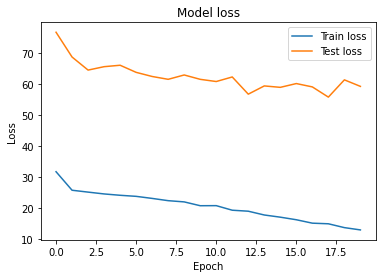

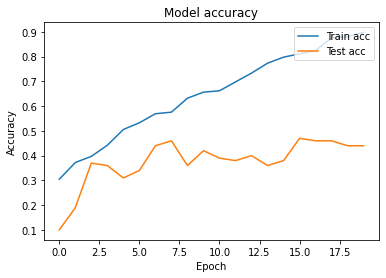

In [ ]:
import matplotlib.pyplot as plt

def plot_loss():
  plt.plot(train_loss_list)
  plt.plot([i*30 for i in val_loss_list])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train loss', 'Test loss'], loc='upper right')
  plt.show()
  return

def plot_acc():
  plt.plot(train_acc_list)
  plt.plot(val_acc_list)
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train acc', 'Test acc'], loc='upper right')
  plt.show()
  return

plot_loss()
plot_acc()

In [ ]:
torch.save(model, dir + "Dcard_School_Classifier-BERT.pkl")

### Load Model

In [ ]:
pip install transformers

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount("/content/drive")

dir = "./drive/My Drive/ML/Final/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
from transformers import BertTokenizer

labels = {'國立臺灣大學': 0, '國立清華大學': 1, '國立交通大學': 2, '國立成功大學': 3, '國立政治大學': 4,
          '國立中央大學': 5, '國立中山大學': 6, '國立中興大學': 7, '國立中正大學': 8, 
          '輔仁大學': 9, '逢甲大學': 10, '東海大學': 11, '義守大學': 12, '中原大學': 13, '其他': 14}
# school_maps = [{'國立臺灣大學': 0, '國立清華大學': 1, '國立交通大學': 2, '國立成功大學': 3, '國立政治大學': 4},
#                {'國立中央大學': 0, '國立中山大學': 1, '國立中興大學': 2, '國立中正大學': 3}]
# labels = {'頂大': 0, '中字輩': 1, '其他': 2}
NUM_LABELS = len(labels)
TITLE_MAX_LEN = 20
MAX_LEN = 50

PRETRAINED_MODEL_NAME = "bert-base-chinese" # pre-trained chinese bert model
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME) # get tokenizer

In [ ]:
DcardSchoolClassifier = torch.load(dir + "Dcard_School_Classifier-BERT.pkl")

In [ ]:
def transform_words_to_tensors(title, content, tokenizer=tokenizer):
  # BERT 輸入層的第一個 token 必是 [CLS]
  word_pieces = ["[CLS]"]

  # 建立標題的 BERT tokens 並加入分隔符號 [SEP]
  tokens_title = tokenizer.tokenize(title)
  word_pieces += tokens_title + ["[SEP]"]
  len_title = len(word_pieces)

  # 建立內文的 BERT tokens 並加入分隔符號 [SEP]
  tokens_content = tokenizer.tokenize(content)
  word_pieces += tokens_content + ["[SEP]"]
  len_content = len(word_pieces) - len_title

  # 將整個 token 序列轉換成索引序列
  ids = tokenizer.convert_tokens_to_ids(word_pieces)
  tokens_tensor = torch.tensor(ids)

  # 將標題包含 [SEP] 的 token 位置設為 0，其他為 1 表示內文
  segments_tensor = torch.tensor([0] * len_title + [1] * len_content, dtype=torch.long)

  # 因為沒有做 zero padding，將全部 mask 起來
  masks_tensor = torch.tensor([1] * len(word_pieces), dtype=torch.long)

  # reshape and put tensors on GPU device
  tokens_tensor = torch.reshape(tokens_tensor, [1, -1]).to("cuda:0")
  segments_tensor = torch.reshape(segments_tensor, [1, -1]).to("cuda:0")
  masks_tensor = torch.reshape(masks_tensor, [1, -1]).to("cuda:0")
  
  return tokens_tensor, segments_tensor, masks_tensor

title = "我是清華大學的學生"
content = "請問梅園的鬼故事是真的嗎？"
tokens_tensor, segments_tensor, masks_tensor = transform_words_to_tensors(title, content[:MAX_LEN])

In [ ]:
import numpy as np

outputs = DcardSchoolClassifier(input_ids=tokens_tensor, 
                                token_type_ids=segments_tensor, 
                                attention_mask=masks_tensor)

def softmax(x):
  exp_x = np.exp(x)
  return exp_x / np.sum(exp_x)

logits = outputs[0].to("cpu").detach().numpy().reshape(-1)
logits = softmax(logits)
print(logits)

[0.03631185 0.03515454 0.07853451 0.09653093 0.04431567 0.05281956
 0.08335377 0.03694259 0.03158455 0.09791005 0.12006859 0.09372734
 0.06233219 0.11908615 0.01132775]
